## Introduction:

Main Goals:

1. Identify the recipients that will engage with the campaign.
2. Maximise the campaign’s revenue.


Comments

- The dataset contains only 5% of donors.
- The donations are usually smaller than $20.
- This data is quite noisy, high dimensional.
- There is an inverse relationship between the probability to donate and the amount donated.


Link for dataset and some analysis ==> 

https://github.com/rebordao/kdd98cup

https://github.com/bobbyantonio/KDD98/blob/master/CleanData.py

- Github solutions ==>
https://github.com/rebordao/kdd98cup


- Siraj notebook for a better data visualization:

https://www.youtube.com/watch?v=yQsOFWqpjkE

In [127]:
import tensorflow as tf
import numpy as np
import scipy.stats as st

from sklearn import datasets, linear_model
from tensorflow.python.ops import rnn, rnn_cell
from sklearn.model_selection import train_test_split
from array_split import array_split, shape_split
from sklearn import preprocessing
# from sknn.mlp import Regressor, Layer
import pandas as pd
import random

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import csv
import sys

import datetime as dt

## warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset:

In [128]:
def load_data():
    list_of_lists = []

    ## works correctly but takes too much running time ..
    with open('mailingData_train.txt', 'r') as f:# open the file for reading
        df = []
        for row_num, line in enumerate(f):
            # Remove the new line at the end and then split the string based on
            # tabs. This creates a python list of the values.
            values = line.strip().split(',')
            if row_num == 0: # first line is the header
                 header = values
            else:
                df.append([v for v in values])

        df = pd.DataFrame(df)
        df.columns = header
        df.drop(df.index[0], inplace=True)
        
        df = df[0:100]  ## to save time .. I gonna work on only 100 records ..
        
        return df

## Data Exploration:

In [129]:
def data_explore():
    df = load_data()
    print df.TARGET_B.value_counts().plot(x=None, y=None, kind = 'pie', autopct='%1.1f%%')
    
    # % of donors
    print 'Percentage of donors: %s' % (100.0 * sum(df.TARGET_B.astype('float'))/df.shape[0]) #about only 5% of the samples are doners .. 
    plt.hist(df.TARGET_D.value_counts(), bins = 7)   
    plt.plot(df[df.TARGET_D > 0].TARGET_D) #Histogram is not the best choice .. let's try another plot .. 
    
    # % of donors
    print 'Percentage of donors: %s' % (100.0 * sum(df.TARGET_D.astype('float'))/df.shape[0])
    #about 79% of the continous predictor are doners .. are there any donation amounts of zero ?!
    print df.TARGET_D.value_counts()

## Gender data imputation ..
It's very strange to have gender rather than M and F !! .. 

Let's impute any other value with the mode of this variable ..

In [130]:
def gender_impute():
    df = load_data()
    df['GENDER'] = np.where(df['GENDER'] == 'C', df['GENDER'].mode(), df['GENDER'])
    df['GENDER'] = np.where(df['GENDER'] == 'U', df['GENDER'].mode(), df['GENDER'])
    df['GENDER'] = np.where(df['GENDER'] == 'J', df['GENDER'].mode(), df['GENDER'])
    df['GENDER'] = np.where(df['GENDER'] == 'A', df['GENDER'].mode(), df['GENDER'])
    df['GENDER'] = np.where(df['GENDER'] == ' ', df['GENDER'].mode(), df['GENDER'])
    
    print df['GENDER'].unique()
    
    ## how donations are distributed per gender
    df['GENDER'].value_counts().plot(kind='barh', stacked=True, fontsize=7, figsize=[9,8], colormap='gist_ncar')
    plt.title('donations are distributed among age groups', fontsize=14, color='black') 
    plt.xlabel('Number of doners', fontsize=14, color='black') 
    plt.ylabel('Gender of doner', fontsize=14, color='black') 

## Data Preprocessing:

1. Gets some redundant variables .. by calculating the correlation between all the variables .. 
those of high correlation coeffecient are redundant .. 

__NOTE:__
In this implementation .. 

https://github.com/EAboelhamd/kdd98cup/blob/master/donors.py

They tried to figure out redundant variables to remove them .. to be able to decrease the dimentionality of the problem .. however, in my case, there is no need to do .. as I'm gonna implement deep learning not a shallow solution .. 

In [131]:
def data_preperation():
    df = load_data()
    df = df[df.columns.difference(['TARGET_B'])]
    data = ['TARGET_D', 'ODATEDW','OSOURCE','TCODE','STATE','ZIP','MAILCODE','PVASTATE','DOB','NOEXCH','RECINHSE','RECP3','RECPGVG','RECSWEEP','MDMAUD','DOMAIN','CLUSTER','AGE','AGEFLAG','HOMEOWNR','CHILD03','CHILD07','CHILD12',
      'CHILD18','NUMCHLD','INCOME','GENDER','WEALTH1','HIT','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE',
      'PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP','DATASRCE','MALEMILI','MALEVET','VIETVETS','WWIIVETS','LOCALGOV','STATEGOV','FEDGOV','SOLP3','SOLIH',
      'MAJOR','WEALTH2','GEOCODE','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER','KIDSTUFF','CARDS','PLATES','LIFESRC','PEPSTRFL','POP901','POP902','POP903','POP90C1','POP90C2','POP90C3','POP90C4','POP90C5','ETH1','ETH2','ETH3','ETH4','ETH5','ETH6','ETH7','ETH8','ETH9','ETH10','ETH11','ETH12','ETH13',
      'ETH14','ETH15','ETH16','AGE901','AGE902','AGE903','AGE904','AGE905','AGE906','AGE907','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC3','AGEC4','AGEC5','AGEC6','AGEC7','CHILC1','CHILC2','CHILC3','CHILC4','CHILC5','HHAGE1','HHAGE2','HHAGE3','HHN1','HHN2','HHN3','HHN4','HHN5','HHN6','MARR1','MARR2','MARR3','MARR4','HHP1','HHP2','DW1','DW2','DW3','DW4','DW5','DW6','DW7','DW8','DW9','HV1','HV2','HV3','HV4','HU1','HU2','HU3','HU4','HU5','HHD1',
      'HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8','HHD9','HHD10','HHD11','HHD12','ETHC1','ETHC2','ETHC3','ETHC4','ETHC5','ETHC6','HVP1','HVP2','HVP3','HVP4',
      'HVP5','HVP6','HUR1','HUR2','RHP1','RHP2','RHP3','RHP4','HUPA1','HUPA2','HUPA3','HUPA4','HUPA5','HUPA6',
      'HUPA7','RP1','RP2', 'RP3','RP4','MSA','ADI','DMA','IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14','IC15','IC16','IC17','IC18','IC19','IC20','IC21','IC22','IC23','HHAS1','HHAS2','HHAS3','HHAS4','MC1','MC2','MC3',
      'TPE1','TPE2','TPE3','TPE4','TPE5','TPE6','TPE7','TPE8','TPE9','PEC1','PEC2','TPE10','TPE11','TPE12','TPE13','LFC1','LFC2','LFC3','LFC4','LFC5','LFC6','LFC7','LFC8','LFC9','LFC10','OCC1','OCC2','OCC3','OCC4','OCC5','OCC6','OCC7','OCC8','OCC9',
      'OCC10','OCC11','OCC12','OCC13','EIC1','EIC2','EIC3','EIC4','EIC5','EIC6','EIC7','EIC8','EIC9','EIC10','EIC11','EIC12','EIC13','EIC14','EIC15',
      'EIC16','OEDC1','OEDC2','OEDC3','OEDC4','OEDC5','OEDC6','OEDC7','EC1','EC2','EC3',
      'EC4','EC5','EC6','EC7','EC8','SEC1','SEC2','SEC3','SEC4','SEC5','AFC1','AFC2','AFC3','AFC4','AFC5','AFC6','VC1','VC2','VC3','VC4','ANC1','ANC2','ANC3','ANC4','ANC5','ANC6','ANC7','ANC8','ANC9','ANC10','ANC11','ANC12','ANC13','ANC14','ANC15','POBC1','POBC2','LSC1','LSC2','LSC3','LSC4',
      'VOC1','VOC2', 'VOC3','HC1','HC2','HC3', 'HC4','HC5','HC6','HC7','HC8','HC9','HC10','HC11','HC12','HC13','HC14','HC15','HC16',
      'HC17','HC18','HC19','HC20','HC21','MHUC1','MHUC2','AC1','AC2','ADATE_2','ADATE_3','ADATE_4','ADATE_5','ADATE_6','ADATE_7','ADATE_8','ADATE_9','ADATE_10','ADATE_11','ADATE_12','ADATE_13','ADATE_14','ADATE_15','ADATE_16','ADATE_17','ADATE_18', 'ADATE_19','ADATE_20','ADATE_21','ADATE_22','ADATE_23',
      'ADATE_24','RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12','RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22','RFA_23','RFA_24','CARDPROM','MAXADATE','NUMPROM',
      'CARDPM12', 'NUMPRM12','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11',
      'RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24','RAMNT_3', 'RAMNT_4','RAMNT_5','RAMNT_6', 'RAMNT_7','RAMNT_8','RAMNT_9', 'RAMNT_10',
      'RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21',
      'RAMNT_22','RAMNT_23','RAMNT_24','RAMNTALL','NGIFTALL','CARDGIFT','MINRAMNT','MINRDATE', 'MAXRAMNT','MAXRDATE','LASTGIFT','LASTDATE','FISTDATE','NEXTDATE','TIMELAG','AVGGIFT','CONTROLN', 'HPHONE_D','RFA_2R','RFA_2F','RFA_2A','MDMAUD_R','MDMAUD_F','MDMAUD_A','CLUSTER2','GEOCODE2']
    
    for i in xrange(len(data)):
        df[data[i]] = pd.Categorical((pd.factorize(df[data[i]])[0] + 1).astype(str))
    
    return df[data]

In [132]:
def df_split():
    df = data_preperation()
    train, test = train_test_split(df, test_size = 0.5)  # split data to 50-50 cross validate 
    return train, test

In [133]:
train, test = df_split()
rewards = ['TARGET_D']
for i in xrange(len(rewards)):
    train[rewards[i]] = pd.Categorical((pd.factorize(train[rewards[i]])[0] + 1).astype(str))

## Current State variables ..
Recency, Frequancy, Montery variables .. ['RFA_2R', 'RFA_2F', 'RFA_2A']

## Rewards:
- Donation amount 
- These are the target variables as well .. 
- TARGET_D, TARGET_B 


## Actions: 
- 11 mailing type

Actions mapping .. 
https://github.com/EAboelhamd/kdd98-1/tree/master/notebooks

## States:

In the cited paper .. they defined the states as follows: 

It is a 5-dimensional vector consisting of 

(1) how recently the donor donated last (R)

(2) how frequently she donates (F)

(3) her average donation amount (M)

(4) how many times PVA sends her a mail in the last six months

(5) how many times PVA has sent her mails.


This implementation is considered as a POMPD .. 
where:
b: belief state that is a probability distribution over all states
b(s): prob. that the agent in state s 
after taking action a and observing the state O .. the update rule for the belief state o(s) is using Bayes rule .. 

## Next States:

As mentioned in the paper ==> the 5-dimensional observation is discrete in this problem, and individual dimensions evolve
independently of each other. We therefore build an observation probability table for each observation dimension,
and the sample next observations using these tables.

Hence, Let's create an n*5 dim observations table .. 

http://www-anw.cs.umass.edu/~barto/courses/cs687/PartialObs-printable.pdf


### These researchers proposed other types of state space ==>

https://www.cs.cmu.edu/~ebrun/15889e/hw1.pdf

as 9 vars (try it out) ;) .. 
and others consider (belief, observation)

In [134]:
def tuple_():
    train, test = df_split()
    
    ## current state ..
    RFA = ['RFA_2R', 'RFA_2F', 'RFA_2A', 'CARDPROM', 'NUMPRM12']  # don't know if it is NUMPRM12 or CARDPM12
#     train[RFA].head()

    ## next state
    ## next_states are random selection from the current states
    next_states = [[random.random() for e in train[RFA].values[0]] for e in xrange(len(train[RFA].values))]
    next_states = pd.DataFrame(next_states)
    

    rewards = ['TARGET_D']
    
    for i in xrange(len(rewards)):
        train[rewards[i]] = pd.Categorical((pd.factorize(train[rewards[i]])[0] + 1).astype(str))
    
    ## actions
    actions = ['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14',
      'RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24']
#     train[actions].head()

    current_states = train[RFA]
    # next_states = train[RFA_]

#     train['TARGET_D']  ## rewards 

    train[actions]  ## actions .. distinct actions are 12

    curr_state_current_action = pd.DataFrame(np.column_stack((current_states, train[actions])))

    # next actions 
    next_actions = np.zeros([len(next_states), max(train[actions].values.max(axis = 0).astype(int)) + 1])
    next_actions = np.delete(next_actions, -1, axis=1) ## remove last column .. 

    next_state_next_action = np.zeros([np.shape(next_states)[0], np.shape(next_states)[1] + max(train[actions].values.max(axis = 0).astype(int)) ])

    # fill in next_actions  
    for i in xrange(np.shape(next_actions)[1]):
        next_actions[:, i] = i

    Mxa0 = Mxa1 = Mxa2 = Mxa3 = Mxa4 = Mxa5 = Mxa6 =  []

    # next_state_next_action
    Mxa0 = pd.DataFrame(np.column_stack((next_states, next_actions[:,0])))
    Mxa1 = pd.DataFrame(np.column_stack((next_states, next_actions[:,1])))
    Mxa2 = pd.DataFrame(np.column_stack((next_states, next_actions[:,2])))
    Mxa3 = pd.DataFrame(np.column_stack((next_states, next_actions[:,3])))
    Mxa4 = pd.DataFrame(np.column_stack((next_states, next_actions[:,4])))
    Mxa5 = pd.DataFrame(np.column_stack((next_states, next_actions[:,5])))
    Mxa6 = pd.DataFrame(np.column_stack((next_states, next_actions[:,6])))
    # next_state_next_action7 = pd.DataFrame(np.column_stack((next_states, next_actions[:,7])))

    tuplesMx = pd.DataFrame(np.column_stack((Mxa0, Mxa1, Mxa2, Mxa3, Mxa4, Mxa5, Mxa6, curr_state_current_action, train[rewards])))
    return tuplesMx, actions

## Regression phase:

Before performing the prediction task .. let's split the data to training and validation sets .. 

To avoid any problems in prediction by having string variables .. let's binarize (catergorize) all the variables .. 

In [135]:
gamma = 0.9
Num_itrs = 10  # no loop 3leha ( w dah el sa7) .. we just have to run the whole algo. 10 times and report the avg. results

num_epoch = 23 #epochs are cycles of Feedforward and Backprob
## el mafrood yeb2a feh loop 3la el epochs elli heyya el steps .. w avg. reward per step is calculated 
batch_size = 5
chunkSize = 3

n_nodes_hl1 = np.shape(train)[0]
n_nodes_hl2 = np.shape(train)[0]
NUM_STATES = np.shape(train)[1]
NUM_DIM =  np.shape(train)[1]
num_nodes = np.shape(train)[0]
num_unrollings = 5

best_actions = np.zeros([np.shape(train)[0], batch_size])
Q_optimal = [] #np.zeros([np.shape(curr_state_current_action)[0], len(df['ACCOUNT_STATUS'].unique())])

########################################################################################################

## for training 
x = tf.placeholder(tf.float32, shape=[NUM_DIM, num_nodes])
y =  tf.placeholder(tf.float32, shape=[num_nodes, 1])

## for testing
x_ = tf.placeholder(tf.float32, shape=[np.shape(test)[0], NUM_DIM])
y_ =  tf.placeholder(tf.float32, shape=[np.shape(test)[0], 1])

########################################################################################################

# Input gate: input, previous output, and bias.
ix = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))# init_weights_RNN([n_nodes_hl1, NUM_ACTIONS])
im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ib = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Forget gate: input, previous output, and bias.
fx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
fb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Memory cell: input, state and bias.                             
cx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
cb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Output gate: input, previous output, and bias.
ox = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ob = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32), trainable=False) #reversed

saved_state = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32), trainable=False) #reversed

# Classifier weights and biases.
w = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
b = tf.Variable(tf.zeros([num_nodes], dtype = tf.float32))

In [136]:
# Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [137]:
def lstm_model(train, saved_output, saved_state):
    # Unrolled LSTM loop.    
    outputs = list()
    output = saved_output  # row !
    state = saved_state  # row !
    
    # astype('U') .. to convert numpy array to string ..
    for i in xrange(np.shape(train)[0]):## el loop faydetha to copy the next line that is just for single unit 
        output_, state = lstm_cell(tf.string_to_number(train.values[i, None].astype('U')), tf.cast(output, tf.float32), tf.cast(state, tf.float32)) 

    ## in case the last values are saved !
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        model_output = tf.matmul(output_, w) + b # outputs single value
        
    return model_output  ## the output for the whole model

In [138]:
def train_lstm_model():
    loss_RNN = []
    model_output = lstm_model(train, saved_output, saved_state) #output here is a vector
    model_output = tf.transpose(model_output)
    cost = tf.reduce_mean(tf.square(y - model_output))
    optimize = tf.train.GradientDescentOptimizer(0.01).minimize(cost) 

    sess = tf.Session()
    init = tf.global_variables_initializer()  ## updated version from initialize_all_variables :) 
    sess.run(init)

    predicted_reward = sess.run(model_output, feed_dict={x:np.transpose(train.values), y:train[rewards]})
    
    # Cost calculation
    for step in xrange(1000):
        l,_ = sess.run([cost, optimize], feed_dict={x:np.transpose(train.values), y:train[rewards]})
        
        if step % 100 == 0:
            loss_RNN.append(l)

    Y_pred = tf.zeros([len(test[rewards]),1])

    # predict 
    test_pred2 = sess.run(Y_pred, feed_dict={x_: test.values})

   ## rms to test ..
    cost_test = tf.reduce_mean(tf.square(test[rewards].values.astype(np.float32) - test_pred2))
    
    
    rmse_val = sess.run(cost_test, feed_dict={x_:test.values.astype(np.float32), y_: test_pred2})
     
    sess.close()
    
    return loss_RNN, predicted_reward #saved_state, saved_output, cost_values

In [139]:
def reward_prediction(train):
    loss_RNN, predicted_reward = train_lstm_model()
    plt.plot(loss_RNN)
    plt.xlabel('Step number')
    plt.ylabel('Prediction Loss')

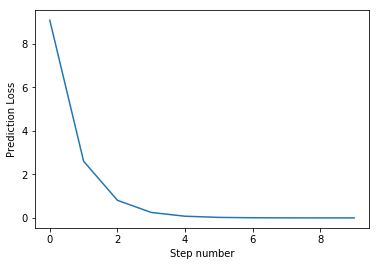

In [140]:
reward_prediction(train)

## Learning the rewards:
Now, the LSTM_RNN output (from validation phase) is considered as input for DQN model, to be able to select the action that has the maximum longtime reward for the customer (highest CLV) .. 

https://arxiv.org/pdf/1602.01580.pdf

## Multilayer Deep Neural Network (DQN):

https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5_Deep_Q_Network/RL_brain.py

## Model Training:

In [141]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=1))

In [142]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [143]:
def DQN_model(X, w_h_1, w_h_2, w_o, bias_I_1, bias_I_2, bias_h):

    layer_1 = tf.matmul(X, w_h_1) + bias_I_1
    layer_1 = tf.nn.relu(layer_1)  ## el performance of softmax outperforms relu!!
    
    layer_2 = tf.matmul(layer_1, w_h_2) + bias_I_2
    layer_2 = tf.nn.sigmoid(layer_2) 

    py_x = tf.matmul(layer_2, w_o) + bias_h
    
    return py_x  #predicted output
    # note that we dont take the softmax at the end because our cost fn does that for us

In [144]:
def DQN_training(X, output):
 
    w_h_1 = init_weights([np.shape(X)[1], n_nodes_hl1]) # create symbolic variables\n",
    w_h_2 = init_weights([n_nodes_hl1, n_nodes_hl2]) # create symbolic variables\n",
    w_o = init_weights([n_nodes_hl2, 1])
    
    bias_I_1=init_weights([n_nodes_hl1])
    bias_I_2=init_weights([n_nodes_hl2])
    bias_h=init_weights([1])
    
    py_x = DQN_model(tf.cast(X, tf.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)  #model training  
        
    cost = tf.reduce_mean(tf.square(py_x - output)) # compute costs",  # excpect float32

    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost) # construct an optimizer\n",
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
#      # Cost calculation
#     for step in xrange(1000):
#         l,_ = sess.run([cost, train_op], feed_dict={x:np.transpose(X), y:np.transpose(output)})
        
#         if step % 100 == 0:
#             loss_RNN.append(l)
            
#     plt.plot(loss_RNN)
    
    sess.close()    
    return w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h

In [145]:
## split dataframe to smaller frames

def splitDataFrameIntoSmaller(df, chunkSize = 3): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    #listOfDf = random.sample(df, chunkSize)  ## in case df is an array not dataframe
    return listOfDf

if only RFM in the state .. 

Mxa0 = (tuplesMx.iloc[:,0:24]).values 
Mxa1 = (tuplesMx.iloc[:,25:48]).values
Mxa2 = (tuplesMx.iloc[:,49:72]).values
Mxa3 = (tuplesMx.iloc[:,73:96]).values
Mxa4 = (tuplesMx.iloc[:,97:120]).values
Mxa5 = (tuplesMx.iloc[:,121:144]).values
Mxa6 = (tuplesMx.iloc[:,145:168]).values

In [146]:
## Prediction phase: 
def DQN_predict(tuplesMx, output):
    
    Mxa0 = (tuplesMx.iloc[:,0:6]).values 
    Mxa1 = (tuplesMx.iloc[:,6:12]).values
    Mxa2 = (tuplesMx.iloc[:,12:18]).values
    Mxa3 = (tuplesMx.iloc[:,18:24]).values
    Mxa4 = (tuplesMx.iloc[:,24:30]).values
    Mxa5 = (tuplesMx.iloc[:,30:36]).values
    Mxa6 = (tuplesMx.iloc[:,36:42]).values

    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa0, output)
    predict_op_0 = DQN_model(Mxa0.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action2     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa1, output)
    predict_op_1 = DQN_model(Mxa1.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    ## print next_state_next_action3
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa2, output)
    predict_op_2 = DQN_model(Mxa2.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa3, output)
    predict_op_3 = DQN_model(Mxa3.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action4    
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa4, output)
    predict_op_4 = DQN_model(Mxa4.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    ## print next_state_next_action5
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa5, output)
    predict_op_5 = DQN_model(Mxa5.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
     
    ## print next_state_next_action6    
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(Mxa6, output)
    predict_op_6 = DQN_model(Mxa6.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)

        
    sess2 = tf.Session()
    init2 = tf.global_variables_initializer()
    sess2.run(init2)

    l0=sess2.run(predict_op_0)
    l1=sess2.run(predict_op_1)
    l2=sess2.run(predict_op_2)
    l3=sess2.run(predict_op_3)
    l4=sess2.run(predict_op_4)
    l5=sess2.run(predict_op_5)
    l6=sess2.run(predict_op_6)
        
    Q_predicted = [l0, l1, l2, l3, l4, l5, l6]
    
    sess2.close()
    return np.transpose(Q_predicted)

Q(s,a) representing the (Quality) of action a at state is .. 

this Q value depends on the immediate reward r .. however, it'll be more effective if it takes the future rewards Q(s', a') into consideration .. 

the future rewards are discounted by probability gama .. cause the evironment is stochastic hence, it is uncertain that each time you select action a you gonna get the same reward r

In [147]:
# predicted_reward = np.transpose(predicted_reward) 
def Q_learning():
    listOfDf = splitDataFrameIntoSmaller(tuplesMx, chunkSize)
    _, actions = tuple_() 
    Q_predicted = np.zeros([np.shape(train)[0], max(train[actions].values.max(axis = 0).astype(int))])
    _, predicted_reward = train_lstm_model()
    
    for i in xrange(chunkSize):
        for j in xrange(batch_size):
            Q_optimal = predicted_reward[j].astype(float) + gamma*np.max(Q_predicted) # returns max value per row !

            Q_optimal = np.array(Q_optimal, dtype=np.float32) # convert output to float32 to match py_x

            Q_predicted = DQN_predict(listOfDf[i].astype(float), Q_optimal)


    print("Mean Optimal Q value is:", np.mean(Q_optimal))
    # print("Q fun. is: ", Q_predicted) ## CLV

In [148]:
def main():
    Q_learning()

In [149]:
main()

('Mean Optimal Q value is:', 1.9275157)


## Note:

an enhancement for this implementation is to change the states to be the whole doner state instead of just RFM ..

https://github.com/EAboelhamd/kdd98-1/blob/master/notebooks/exploratory.ipynb

Do I apply experience replay .. 

The algorithm is mentioned here .. 

https://www.intelnervana.com/demystifying-deep-reinforcement-learning/